# PRUEBA DATA SCIENCE - Grupo Hotusa

In [203]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

In [204]:
file = "hotusa_cancellations.csv"
df = pd.read_csv(file)

### 1. EDA

In [205]:
# Vemos el dataframe
df.head()

,Unnamed: 0,HotelId,ReservationStatusDate,ArrivalDate,LeadTime,StaysInWeekendNights,StaysInWeekNights,Adults,Children,CustomerType,ADR,Meal,Country,Company,ReservedRoomType,IsRepeatedGuest,IsCanceled
0,10043,1,2016-12-15,2017-02-10,238,0,2,2,0,Transient,54.00,HB,PRT,NULL,A,False,True
1,19043,1,2015-12-07,2016-05-27,174,2,5,2,1,Transient,108.02,BB,PRT,NULL,F,False,True
2,3509,1,2015-08-24,2015-12-20,260,4,9,1,0,Transient,47.54,BB,PRT,NULL,D,False,True
3,5012,1,2016-01-05,2016-04-12,168,0,2,2,0,Transient,86.00,HB,PRT,NULL,A,False,True
4,17991,1,2015-11-11,2015-11-11,1,0,1,1,0,Transient,35.00,BB,PRT,88,A,True,True


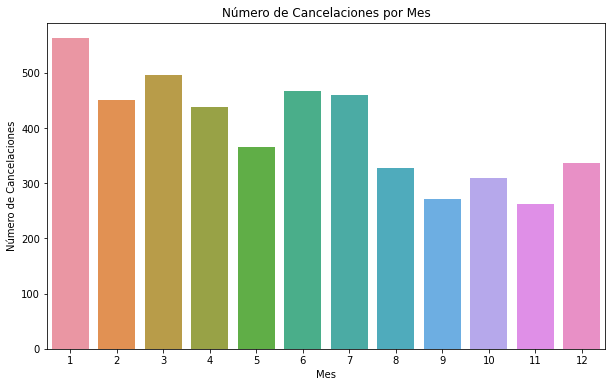

In [206]:
# Histograma cancelaciones por mes

df['ReservationStatusDate'] = pd.to_datetime(df['ReservationStatusDate'])

df['Month'] = df['ReservationStatusDate'].dt.month

cancelaciones_mes = df[df['IsCanceled'] == True].groupby('Month').size()

plt.figure(figsize=(10, 6))
sns.barplot(x=cancelaciones_mes.index, y=cancelaciones_mes.values)
plt.title('Número de Cancelaciones por Mes')
plt.xlabel('Mes')
plt.ylabel('Número de Cancelaciones')
plt.show()

In [207]:
reservas_por_mes = df.groupby('Month').size()

cancelaciones_por_mes = df[df['IsCanceled'] == True].groupby('Month').size()

porcentaje_cancelaciones = (cancelaciones_por_mes / reservas_por_mes) * 100

porcentaje_cancelaciones

Month
1     21.221259
2     16.759569
3     16.956670
4     14.762386
5     12.568681
6     18.720000
7     13.383765
8      9.095967
9     10.836653
10    10.453315
11    10.867769
12    15.879017
dtype: float64

### 2. Preparación de los datos

#### ¿Le darías el mismo tratamiento a todas las variables?
#### Dependiendo de la tipología de la variable. Las cualitativas le haré one-hot encoding, las variables discretas las normalizaré y otras como las noches de la reserva, al ser variables continuas no las normalizaré. Además crearé una variable que me diga las noches totales de la reserva sin discernir entre las que sean fin de semana y entre semana.

#### ¿Utilizarías todas las variables o eliminarías alguna de ellas por no ofrecer valor?
#### No usaré ningún método de selección de variables debido al poco número de variables, solo dejaré de usar "HotelId" ya que no aporta ningún valor porque en todas las filas de la columna el valor es 1, "ReservationStatusDate" y "ArrivalDate" no los usaré ya que "LeadTime" es una consecuencia de ellas. Las variables como noches entre semana y fin de semana la elimino por lo que comentaba anteriormente. Y "company" tampoco la voy a usar porque la mayoría de datos de esta variable son nulos.

In [208]:
# Convertimos las variables categóricas en one-hot encoding
df1 = pd.get_dummies(df, columns=['Meal'], prefix='Meal')
df2 = pd.get_dummies(df1, columns=['Month'], prefix='Month')
df3 = pd.get_dummies(df2, columns=['CustomerType'], prefix='CustomerType')
df4 = pd.get_dummies(df3, columns=['ReservedRoomType'], prefix='ReservedRoomType')

df4.replace({True: 1, False: 0}, inplace=True)

# Estandarizamos la variable de media de precios y la de días de antelación
scaler = StandardScaler()
df4['ADR'] = scaler.fit_transform(df4[['ADR']])
df4['LeadTime'] = scaler.fit_transform(df4[['LeadTime']])

# Nueva variable con las noches totales sin especificar si es durante semana o fin de semana
df4['TotalNights'] = df4['StaysInWeekendNights'] + df4['StaysInWeekNights']

df4.head()

,Unnamed: 0,HotelId,ReservationStatusDate,ArrivalDate,LeadTime,StaysInWeekendNights,StaysInWeekNights,Adults,Children,ADR,...,ReservedRoomType_A,ReservedRoomType_B,ReservedRoomType_C,ReservedRoomType_D,ReservedRoomType_E,ReservedRoomType_F,ReservedRoomType_G,ReservedRoomType_H,ReservedRoomType_L,TotalNights
0,10043,1,2016-12-15,2017-02-10,1.590471,0,2,2,0,-0.645227,...,1,0,0,0,0,0,0,0,0,2
1,19043,1,2015-12-07,2016-05-27,0.920919,2,5,2,1,0.250955,...,0,0,0,0,0,1,0,0,0,7
2,3509,1,2015-08-24,2015-12-20,1.820630,4,9,1,0,-0.752397,...,0,0,0,1,0,0,0,0,0,13
3,5012,1,2016-01-05,2016-04-12,0.858148,0,2,2,0,-0.114353,...,1,0,0,0,0,0,0,0,0,2
4,17991,1,2015-11-11,2015-11-11,-0.888965,0,1,1,0,-0.960434,...,1,0,0,0,0,0,0,0,0,1


In [209]:
conteo_valores = df['HotelId'].value_counts()

print(conteo_valores)

HotelId
1    33688
Name: count, dtype: int64


In [210]:
value_counts = df['CustomerType'].value_counts()

print(value_counts)


CustomerType
Transient          24818
Transient-Party     6918
Contract            1684
Group                268
Name: count, dtype: int64


In [211]:
value_counts = df['Company'].value_counts()

print(value_counts)


Company
       NULL    30819
        223      718
        154      129
        281      129
        405       88
               ...  
        422        1
        362        1
        425        1
        424        1
        410        1
Name: count, Length: 227, dtype: int64


In [212]:
value_counts = df['Country'].value_counts()

print(value_counts)

Country
PRT    13385
GBR     6290
ESP     3471
IRL     1923
FRA     1490
       ...  
SMR        1
MKD        1
CYM        1
ZMB        1
DJI        1
Name: count, Length: 118, dtype: int64


In [213]:
# Checkeamos que no haya falta de datos en las variables, solo hay en Country, y no la vamos a usar, asi que no se hace nada 

datos_faltantes = df.isnull().sum()

print(datos_faltantes)

Unnamed: 0                 0
HotelId                    0
ReservationStatusDate      0
ArrivalDate                0
LeadTime                   0
StaysInWeekendNights       0
StaysInWeekNights          0
Adults                     0
Children                   0
CustomerType               0
ADR                        0
Meal                       0
Country                  432
Company                    0
ReservedRoomType           0
IsRepeatedGuest            0
IsCanceled                 0
Month                      0
dtype: int64


### 3. Construcción del modelo

#### Voy a usar un modelo de red neuronal para predecir las cancelaciones por estos motivos: Capacidad de Capturar Patrones Complejos y tienden a beneficiarse de grandes conjuntos de datos.

In [214]:
# Variable objetivo es 'IsCanceled', y las explicativas  son el resto 
# excepto 'Company', 'Country', 'Unnamed: 0', 'HotelId', 'ReservationStatusDate', 'ArrivalDate'.

x_no_elegidas = ['Company', 'Country', 'Unnamed: 0', 'HotelId', 'ReservationStatusDate', 'ArrivalDate', 'StaysInWeekendNights', 'StaysInWeekNights']
y_obj = 'IsCanceled'

# Variables predictoras (explicativas)
X = df4.drop(columns=[y_obj] + x_no_elegidas)

# Variable objetivo
y = df4[y_obj]

In [215]:
# Dividimos df en entrenamiento y prueba.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [216]:
# Convertir datos a tensores de PyTorch
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [217]:
# Definir la arquitectura de la red neuronal
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.layer2 = nn.Linear(64, 32)
        self.output_layer = nn.Linear(32, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = torch.sigmoid(self.output_layer(x))
        return x

In [218]:
# Inicializamos la red neuronal
input_size = X_train.shape[1]  # Ajustar el tamaño de entrada al número de variables predictivas
model = NeuralNetwork(input_size)

In [219]:
# Función de pérdida y optimizador
criterion = nn.BCELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch [1/1000], Loss: 0.6782
Epoch [2/1000], Loss: 0.6668
Epoch [3/1000], Loss: 0.6558
Epoch [4/1000], Loss: 0.6452
Epoch [5/1000], Loss: 0.6350
Epoch [6/1000], Loss: 0.6251
Epoch [7/1000], Loss: 0.6152
Epoch [8/1000], Loss: 0.6054
Epoch [9/1000], Loss: 0.5957
Epoch [10/1000], Loss: 0.5860
Epoch [11/1000], Loss: 0.5762
Epoch [12/1000], Loss: 0.5664
Epoch [13/1000], Loss: 0.5567
Epoch [14/1000], Loss: 0.5469
Epoch [15/1000], Loss: 0.5372
Epoch [16/1000], Loss: 0.5276
Epoch [17/1000], Loss: 0.5181
Epoch [18/1000], Loss: 0.5088
Epoch [19/1000], Loss: 0.4997
Epoch [20/1000], Loss: 0.4910
Epoch [21/1000], Loss: 0.4826
Epoch [22/1000], Loss: 0.4746
Epoch [23/1000], Loss: 0.4672
Epoch [24/1000], Loss: 0.4603
Epoch [25/1000], Loss: 0.4541
Epoch [26/1000], Loss: 0.4485
Epoch [27/1000], Loss: 0.4436
Epoch [28/1000], Loss: 0.4394
Epoch [29/1000], Loss: 0.4359
Epoch [30/1000], Loss: 0.4330
Epoch [31/1000], Loss: 0.4307
Epoch [32/1000], Loss: 0.4289
Epoch [33/1000], Loss: 0.4274
Epoch [34/1000], Lo

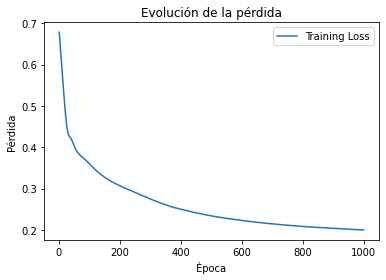

In [220]:
# Entrenamiento de la red neuronal
train_loss = []
epochs = 1000

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    # Almacenamiento de la pérdida en cada época
    train_loss.append(loss.item())
    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Graficamos evolución de la pérdida
plt.plot(range(1, epochs + 1), train_loss, label='Training Loss')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Evolución de la pérdida')
plt.legend()
plt.show()

### 4. Evaluación del modelo
#### Creo una matriz de confusión porque nos permite visualizar el desempeño de un algoritmo que usamos. Y dada la precisión del modelo, podemos decir que estamos satisfechos con el resultado y el rendimiento del mismo.
#### En cuanto al benchmark a batir, podríamos comparar estos resultados con algun modelo previo usado para el mismo fin.

In [221]:
# Evaluar el modelo en el conjunto de prueba
model.eval()
with torch.no_grad():
    test_output = model(X_test_tensor)
    predictoras = (test_output >= 0.5).float()  
    precision = accuracy_score(y_test_tensor.numpy(), predictoras.numpy())
    print(f'Precisión en el conjunto de test: {precision*100:.2f}%')

Precisión en el conjunto de test: 91.63%


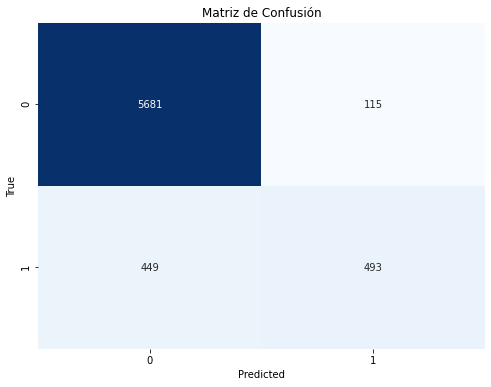


Informe clasificación:
               precision    recall  f1-score   support

         0.0       0.93      0.98      0.95      5796
         1.0       0.81      0.52      0.64       942

    accuracy                           0.92      6738
   macro avg       0.87      0.75      0.79      6738
weighted avg       0.91      0.92      0.91      6738



In [222]:
# Evaluar el modelo en el conjunto de prueba
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    predicted_labels = (test_outputs >= 0.5).float()  # Convertir probabilidades a etiquetas binarias

# Convertir las etiquetas de PyTorch a NumPy
y_true = y_test_tensor.numpy()
y_pred = predicted_labels.numpy()

# Crear la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión con seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.show()

# Imprimir el informe de clasificación
print("\nInforme clasificación:\n", classification_report(y_true, y_pred))


### Para finalizar, en cuanto al deployment de este modelo, y confiando en nuestra precisión del 90% de acierto en la predicción de la cancelación de las reservas, ya podemos pronosticar que reservas si serán canceladas y cuales no, por lo tanto podemos llevar a cabo un plan para hacer overbooking en el hotel teniendo la certeza de que tendremos un gran acierto y así disminuir en la medida lo posible la pérdida que suponen las cancelaciones en nuestro hotel.